In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *

query = {'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
         'expansions__vectors__dimensionality': 100,
         'expansions__vectors__rep': 0,
         'expansions__vectors__unlabelled': 'turian'}

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


ids are [38, 39, 40, 41, 42]
Accuracy has 2500 values
Algorithm has 2500 values
Composer has 2500 values
Features has 2500 values
folds has 2500 values


DoesNotExist: Results matching query does not exist.

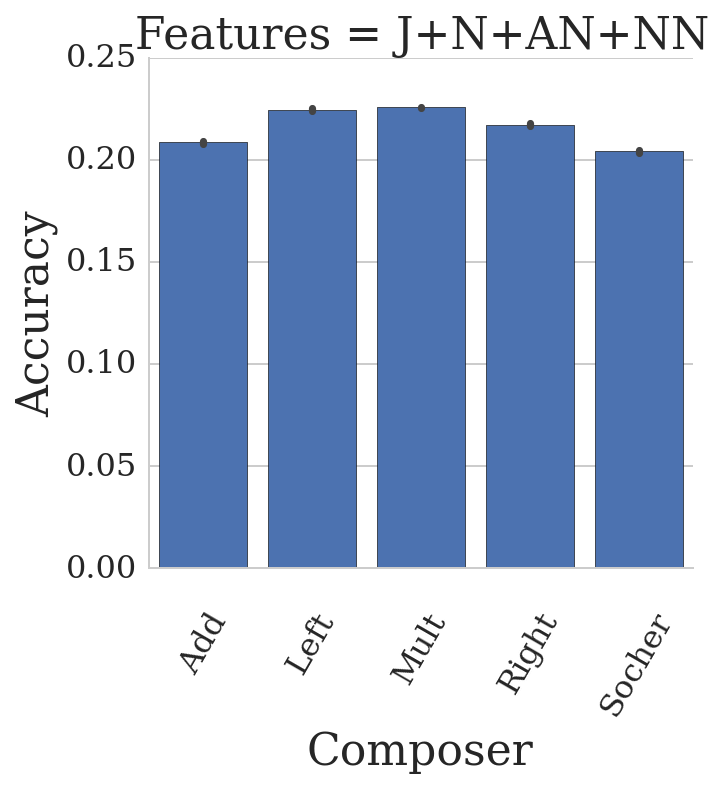

In [2]:
ids = Experiment.objects.filter(**query).values_list('id', flat=True)
print('ids are', ids)
df = dataframe_from_exp_ids(ids, {'Algorithm':'expansions__vectors__algorithm', 
                                  'Composer':'expansions__vectors__composer',
                                 'Features': 'document_features_tr'})
grid = sns.factorplot(hue='Algorithm', y='Accuracy', data=df, 
                      x='Composer', col='Features',
                      kind='bar', legend=False);
grid.set_xticklabels(rotation=60);
for ax in grid.axes.flat:
#     ax.axhline(nondistributional_baseline(), c='k')
    ax.axhline(random_vect_baseline(), c='k')
plt.savefig('plot-turian-different-composers.pdf', format='pdf', dpi=30s0)

In [3]:
df.head()

,Accuracy,Algorithm,Composer,Features,folds
0,0.188823,turian,Add,J+N+AN+NN,0
1,0.191138,turian,Add,J+N+AN+NN,1
2,0.191468,turian,Add,J+N+AN+NN,2
3,0.191799,turian,Add,J+N+AN+NN,3
4,0.191799,turian,Add,J+N+AN+NN,4


In [4]:
def f1(x):
    return '%1.2f' % x

# ddf = df.drop('folds', axis=1).groupby(['Composer', 'k']).agg([np.mean, np.std])
# ddf.columns = ddf.columns.droplevel(0)#.reset_index()
# ddf['Accuracy'] = ddf['mean'].map(f1) + "$\pm$" + ddf['std'].map(f1)
# ddf = ddf.drop(['mean', 'std'], axis=1).reset_index()
# print(ddf.pivot_table(values='Accuracy', index='k', 
#                       columns='Composer', aggfunc=lambda x: x).to_latex(escape=False))

ddf = df.drop(['folds', 'Algorithm'], axis=1).groupby(['Composer', 'Features']).agg('mean').reset_index() # no need to drop unwanted columns
res = ddf.pivot_table(values='Accuracy', index='Composer', columns='Features')
print(res.to_latex(float_format=f1, na_rep='N/A'))
res.T

\begin{tabular}{lr}
\toprule
Features &  J+N+AN+NN \\
\midrule
Composer &            \\
Add      &       0.21 \\
Left     &       0.22 \\
Mult     &       0.23 \\
Right    &       0.22 \\
Socher   &       0.20 \\
\bottomrule
\end{tabular}



Composer,Add,Left,Mult,Right,Socher
Features,,,,,
J+N+AN+NN,0.208615,0.224618,0.225724,0.217248,0.204364


In [5]:
del res.index.name
del res.columns.name
for c in res.columns:
    print(res[[c]].to_latex(float_format=f1, na_rep='N/A'))
res[[c]]

\begin{tabular}{lr}
\toprule
{} &  J+N+AN+NN \\
\midrule
Add    &       0.21 \\
Left   &       0.22 \\
Mult   &       0.23 \\
Right  &       0.22 \\
Socher &       0.20 \\
\bottomrule
\end{tabular}



,J+N+AN+NN
Add,0.208615
Left,0.224618
Mult,0.225724
Right,0.217248
Socher,0.204364


In [6]:
ddf.index

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [7]:
del res.index.name
res

AttributeError: name

In [ ]:
del res.columns.name
res